# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [30]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [31]:
batch_size_train = 64
batch_size_test = 1000

In [32]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [33]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

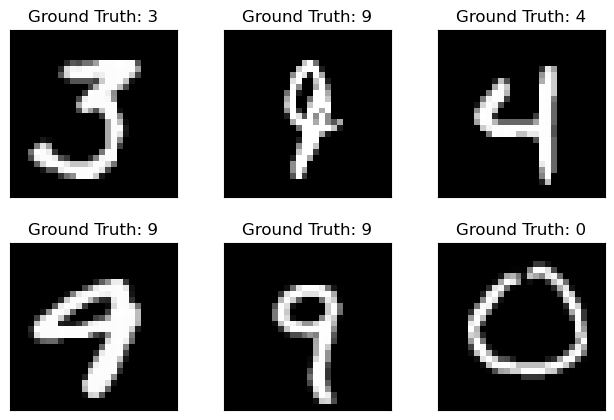

In [34]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [36]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) # a dense layer that maps input features to output features

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out) # log prob

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [37]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [38]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [39]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [40]:
! mkdir -p results

In [41]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [42]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.040590
Train Epoch: 1 [13440/60000 (22%)]	Loss: 1.126434
Train Epoch: 1 [14080

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [43]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [44]:
test()

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [45]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488055
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554512
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585008
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.680402
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.570716
Train Epoch: 2 [14720/60000 (25%)]	Loss: 0.624158
Train Epoch: 2 [1

## Model performance

Finally, we can inspect the results.

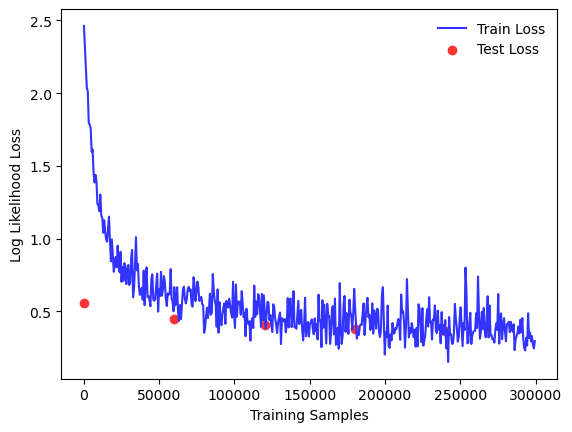

In [46]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [47]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

- This is a function that disables gradient calculation during the evaluation phase. This step helps to prevent the update of model parameters during validation or testing, which helps reduce memory usage.

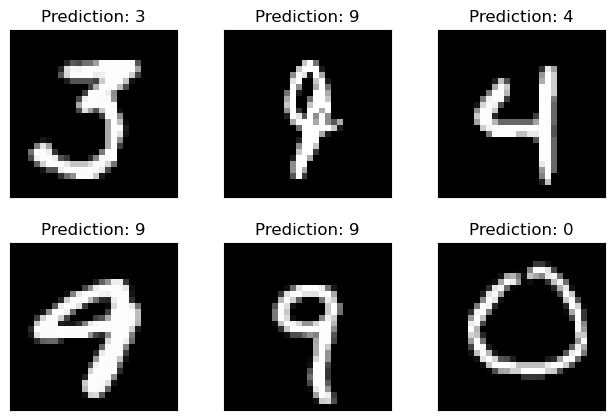

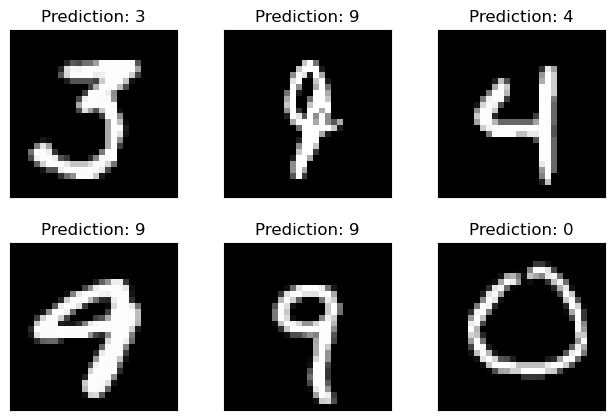

In [48]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

`output` shape: [batch_size, num_classes]

each row correspond to one image, and the values are log probability for each class. 

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

In [49]:
predictions = output.data.max(1, keepdim=True)[1]

In [50]:
# Check for misclassification
missclassification = []
for i in range(len(example_data)):
    if predictions[i].item() != example_targets[i].item():  
        missclassification.append(i)

In [51]:
len(missclassification)

95

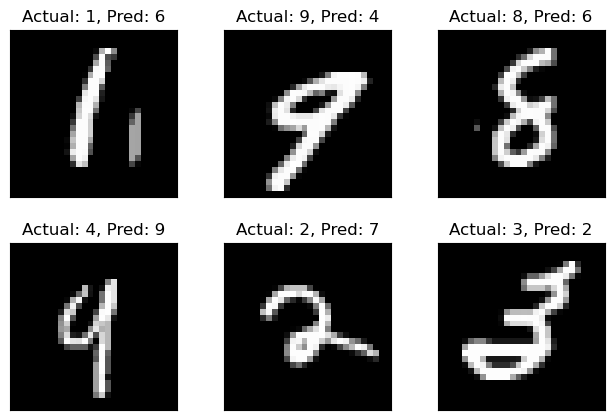

In [52]:
fig = pl.figure()
for j in range(6):
    i = missclassification[j]
    pl.subplot(2, 3, j + 1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Actual: {}, Pred: {}".format(example_targets[i].item(), predictions[i].item()))
    pl.xticks([])
    pl.yticks([])

pl.show()

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [53]:
! ls results

model_iteration-1.pth     model_iteration-5.pth     optimizer_iteration-4.pth
model_iteration-2.pth     optimizer_iteration-1.pth optimizer_iteration-5.pth
model_iteration-3.pth     optimizer_iteration-2.pth
model_iteration-4.pth     optimizer_iteration-3.pth


To load a model:

In [54]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/511041913.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("results/model_i

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [55]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [56]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

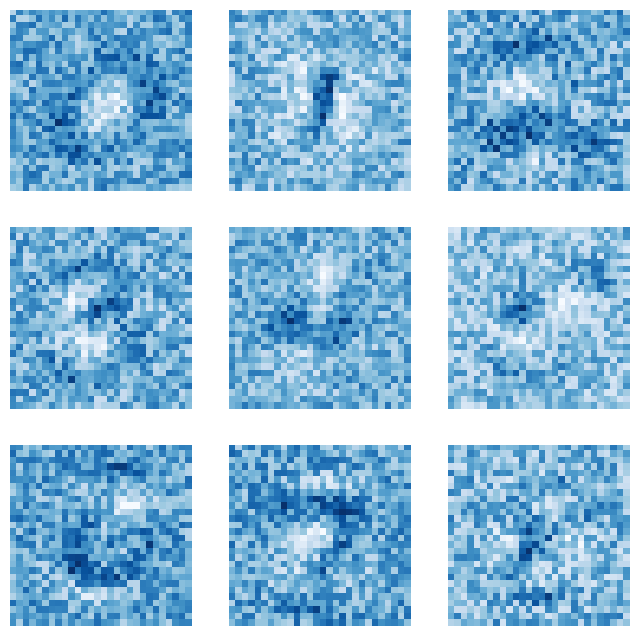

In [57]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [58]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/1021501824.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_state_dict = torch.load("results/op

In [59]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

In [60]:
optimizer_state_dict['state']

{0: {'momentum_buffer': tensor([[-1.3096e-03, -1.3096e-03, -1.3096e-03,  ..., -1.3096e-03,
           -1.3096e-03, -1.3096e-03],
          [ 9.4556e-05,  9.4556e-05,  9.4556e-05,  ...,  9.4556e-05,
            9.4556e-05,  9.4556e-05],
          [ 7.4225e-03,  7.4225e-03,  7.4225e-03,  ...,  7.4225e-03,
            7.4225e-03,  7.4225e-03],
          ...,
          [-3.4549e-04, -3.4549e-04, -3.4549e-04,  ..., -3.4549e-04,
           -3.4549e-04, -3.4549e-04],
          [ 5.1118e-03,  5.1118e-03,  5.1118e-03,  ...,  5.1118e-03,
            5.1118e-03,  5.1118e-03],
          [-4.0428e-03, -4.0428e-03, -4.0428e-03,  ..., -4.0428e-03,
           -4.0428e-03, -4.0428e-03]])},
 1: {'momentum_buffer': tensor([ 3.0871e-03, -2.2290e-04, -1.7497e-02, -1.0883e-02,  1.6721e-02,
           3.4171e-05,  1.0465e-02,  8.1442e-04, -1.2050e-02,  9.5301e-03])}}

In [61]:
optimizer_state_dict['param_groups']

[{'lr': 0.001,
  'momentum': 0.1,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None,
  'params': [0, 1]}]

**Challenge:** Can you make sense of the data in this dictionary?

- The `state` in this dictionary stores momentum buffers for each parameters in the network (in this case, 0 and 1). It stores the exponentially decaying sum of past gradients. 
- The `param_groups` stores the parameter groups used by the optimizer, including potentially different hyperparameters.

## Final challenges

#### 1. What happens if you use only 10% of the available training data? Plot the difference in performance of the network.

In [62]:
len(train_loader.dataset)

60000

In [63]:
# get subset of training data
size = int(0.1 * len(train_loader.dataset))
print(size)
train_loader_subset = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_loader.dataset, range(size)),
    batch_size=batch_size_train,
    shuffle=True
)

6000


In [64]:
# store the performance of the full dataset
train_losses_full = train_losses
test_losses_full = test_losses

In [65]:
# build new model for partial training data
network_partial = FeedforwardNeuralNetModel()
optimizer_partial = optim.SGD(network_partial.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

train_losses_partial = []
train_counter_partial = []
test_losses_partial = []
test_counter_partial = [i*len(train_loader_subset.dataset) for i in range(n_epochs + 1)]

In [66]:
! mkdir -p results_subset

In [67]:
def train_partial(epoch):
    network_partial.train()
    for batch_idx, (data, target) in enumerate(train_loader_subset):
        optimizer_partial.zero_grad() # clears gradients
        output_partial = network_partial(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output_partial, target)
        loss.backward()
        
        optimizer_partial.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_subset.dataset),
                100. * batch_idx / len(train_loader_subset), loss.item())
            )
            train_losses_partial.append(loss.item())
            train_counter_partial.append((batch_idx*64) + ((epoch-1)*len(train_loader_subset.dataset)))
            torch.save(network_partial.state_dict(), f'./results_subset/model_iteration-{epoch}.pth')
            torch.save(optimizer_partial.state_dict(), f'./results_subset/optimizer_iteration-{epoch}.pth')

In [68]:
def test_partial():
    network_partial.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_partial = network_partial(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output_partial, target, size_average=False).item()
            pred = output_partial.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_partial.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [69]:
# train the model on partial training data
for epoch in range(1, n_epochs + 1): 
  train_partial(epoch)
  test_partial()

Train Epoch: 1 [0/6000 (0%)]	Loss: 2.387693


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/6000 (11%)]	Loss: 2.262907
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.063719
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.023601
Train Epoch: 1 [2560/6000 (43%)]	Loss: 1.905689
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.801596
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.759712
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.592667
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.500170
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.495899

Test set: Avg. loss: 1.4904, Accuracy: 6412/10000 (64%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 1.460441
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.421678
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.285988
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.259769
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.367833
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.382225
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.280855
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.273919
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.282933
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1.081800

Test set: Avg. loss: 1.1290, Accura

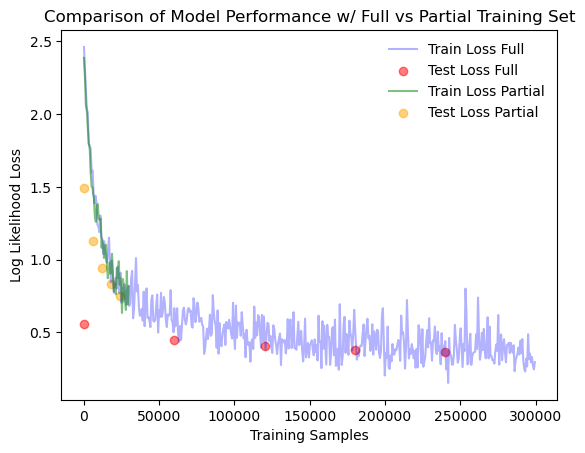

In [127]:
# plot the training and testing losses of the two rounds together
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3)
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5)
pl.plot(train_counter_partial, train_losses_partial, color="green", alpha=0.5)
pl.scatter(test_counter_partial[:-1], test_losses_partial, color="orange", alpha=0.5)


pl.legend(['Train Loss Full', 'Test Loss Full', 'Train Loss Partial', 'Test Loss Partial'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Full vs Partial Training Set")

pl.show()

According to the plot, as the number of training samples increases, the training loss decreases. The dots showcase how well the models generalize to unseen data. For the model trained on the full training set, the test loss tend to converge to lower values, while the model trained on partial training set have higher test losses. In summary, using more training data improves model performance by reducing both training and testing losses. 

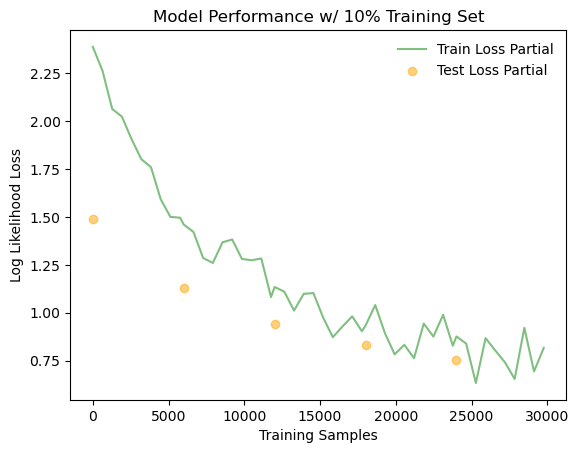

In [71]:
# plot the performance of the model trained on 10% of training data
fig = pl.figure()
pl.plot(train_counter_partial, train_losses_partial, color="green", alpha=0.5)
pl.scatter(test_counter_partial[:-1], test_losses_partial, color="orange", alpha=0.5)


pl.legend(['Train Loss Partial', 'Test Loss Partial'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Model Performance w/ 10% Training Set")

pl.show()

#### 2. What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?

In [72]:
import random
from torch.utils.data import Subset

In [73]:
random.seed(42)
# select the indices to remove
indices_label_5 = [i for i, (_, label) in enumerate(train_loader.dataset) if label == 5]
indices_to_remove = random.sample(indices_label_5, int(0.8*len(indices_label_5)))

In [135]:
# count of labels in training set
label_count = {}
for j in range(10):
    label_count[j] = len([i for i, (_, label) in enumerate(train_loader.dataset) if label == j])
label_count

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [74]:
indices_to_keep = [i for i in range(len(train_loader.dataset)) if i not in indices_to_remove]
dataset_remove_samples = Subset(train_loader.dataset, indices_to_keep)
train_loader_remove_samples = torch.utils.data.DataLoader(
    dataset_remove_samples,
    batch_size=batch_size_train,
    shuffle=True)

In [75]:
network_remove_samples = FeedforwardNeuralNetModel()
optimizer_remove_samples = optim.SGD(network_remove_samples.parameters(), lr=0.001, momentum=0.9)

n_epochs = 5

train_losses_remove_samples = []
train_counter_remove_samples = []
test_losses_remove_samples = []
test_counter_remove_samples = [i*len(train_loader_remove_samples.dataset) for i in range(n_epochs + 1)]

In [76]:
! mkdir -p results_remove_samples

In [77]:
def train_remove_samples(epoch):
    network_remove_samples.train()
    for batch_idx, (data, target) in enumerate(train_loader_remove_samples):
        optimizer_remove_samples.zero_grad() # clears gradients
        output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output_remove_samples, target)
        loss.backward()
        
        optimizer_remove_samples.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_remove_samples.dataset),
                100. * batch_idx / len(train_loader_remove_samples), loss.item())
            )
            train_losses_remove_samples.append(loss.item())
            train_counter_remove_samples.append((batch_idx*64) + ((epoch-1)*len(train_loader_remove_samples.dataset)))
            torch.save(network_remove_samples.state_dict(), f'./results_remove_samples/model_iteration-{epoch}.pth')
            torch.save(optimizer_remove_samples.state_dict(), f'./results_remove_samples/optimizer_iteration-{epoch}.pth')

In [78]:
def test_remove_samples():
    network_remove_samples.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output_remove_samples, target, size_average=False).item()
            pred = output_remove_samples.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_remove_samples.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [79]:
for epoch in range(1, n_epochs + 1): 
  train_remove_samples(epoch)
  test_remove_samples()

Train Epoch: 1 [0/55664 (0%)]	Loss: 2.562619
Train Epoch: 1 [640/55664 (1%)]	Loss: 1.992052


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1280/55664 (2%)]	Loss: 1.215330
Train Epoch: 1 [1920/55664 (3%)]	Loss: 0.996824
Train Epoch: 1 [2560/55664 (5%)]	Loss: 0.854361
Train Epoch: 1 [3200/55664 (6%)]	Loss: 0.668104
Train Epoch: 1 [3840/55664 (7%)]	Loss: 0.653710
Train Epoch: 1 [4480/55664 (8%)]	Loss: 0.564876
Train Epoch: 1 [5120/55664 (9%)]	Loss: 0.602630
Train Epoch: 1 [5760/55664 (10%)]	Loss: 0.593732
Train Epoch: 1 [6400/55664 (11%)]	Loss: 0.451958
Train Epoch: 1 [7040/55664 (13%)]	Loss: 0.514672
Train Epoch: 1 [7680/55664 (14%)]	Loss: 0.525508
Train Epoch: 1 [8320/55664 (15%)]	Loss: 0.520837
Train Epoch: 1 [8960/55664 (16%)]	Loss: 0.476823
Train Epoch: 1 [9600/55664 (17%)]	Loss: 0.498750
Train Epoch: 1 [10240/55664 (18%)]	Loss: 0.491461
Train Epoch: 1 [10880/55664 (20%)]	Loss: 0.660895
Train Epoch: 1 [11520/55664 (21%)]	Loss: 0.550650
Train Epoch: 1 [12160/55664 (22%)]	Loss: 0.358510
Train Epoch: 1 [12800/55664 (23%)]	Loss: 0.340577
Train Epoch: 1 [13440/55664 (24%)]	Loss: 0.456177
Train Epoch: 1 [14080

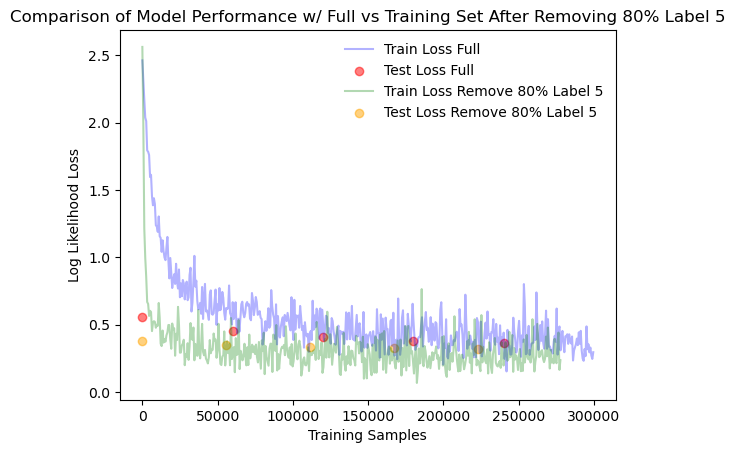

In [128]:
# plot the training and testing losses of the two rounds together
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3)
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5)
pl.plot(train_counter_remove_samples, train_losses_remove_samples, color="green", alpha=0.3)
pl.scatter(test_counter_remove_samples[:-1], test_losses_remove_samples, color="orange", alpha=0.5)


pl.legend(['Train Loss Full', 'Test Loss Full', 'Train Loss Remove 80% Label 5', 'Test Loss Remove 80% Label 5'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Full vs Training Set After Removing 80% Label 5")

pl.show()

According to this plot, the training and testing losses seem to decrease after removing 80% of the training samples that are labeled 5. In my opinion, this can be due to several reasons:
1. The model could be biased toward the classes with more samples, leading to better performance (lower errors) on these classes. 
2. The misclassifications of class 5 are not penalized heavily because of the lower count of class 5 samples. 

In [81]:
correct_by_class_remove_samples = [0] * 10  
total_by_class_remove_samples = [0] * 10 # total samples

# Calculate per-class accuracy in testing set
with torch.no_grad():
    for data, target in test_loader:
        output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
        pred = output_remove_samples.data.max(1, keepdim=True)[1]

        for i in range(len(target)):
            total_by_class_remove_samples[target[i].item()] += 1
            if pred[i].item() == target[i].item(): # correct prediction
                correct_by_class_remove_samples[target[i].item()] += 1

class_accuracies_remove_samples = [
    correct_by_class_remove_samples[i] / total_by_class_remove_samples[i] if total_by_class_remove_samples[i] > 0 else 0
    for i in range(10)
]

for i, accuracy in enumerate(class_accuracies_remove_samples):
    print(f'Accuracy for class {i}: {accuracy * 100:.2f}%')

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy for class 0: 98.16%
Accuracy for class 1: 97.71%
Accuracy for class 2: 88.86%
Accuracy for class 3: 92.57%
Accuracy for class 4: 93.28%
Accuracy for class 5: 69.28%
Accuracy for class 6: 95.82%
Accuracy for class 7: 91.93%
Accuracy for class 8: 90.35%
Accuracy for class 9: 89.40%


In [82]:
correct_by_class_full = [0] * 10
total_by_class_full = [0] * 10

# Calculate per-class accuracy for the full training set model in testing set
with torch.no_grad():
    for data, target in test_loader:
        output_full = network(data.reshape(-1, 28*28))
        pred = output_full.data.max(1, keepdim=True)[1]

        for i in range(len(target)):
            total_by_class_full[target[i].item()] += 1
            if pred[i].item() == target[i].item():
                correct_by_class_full[target[i].item()] += 1

class_accuracies_full = [
    correct_by_class_full[i] / total_by_class_full[i] if total_by_class_full[i] > 0 else 0
    for i in range(10)
]

for i, accuracy in enumerate(class_accuracies_full):
    print(f'Accuracy for class {i} (Full): {accuracy * 100:.2f}%')

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy for class 0 (Full): 97.55%
Accuracy for class 1 (Full): 96.39%
Accuracy for class 2 (Full): 85.47%
Accuracy for class 3 (Full): 88.61%
Accuracy for class 4 (Full): 92.06%
Accuracy for class 5 (Full): 83.52%
Accuracy for class 6 (Full): 93.53%
Accuracy for class 7 (Full): 89.79%
Accuracy for class 8 (Full): 86.14%
Accuracy for class 9 (Full): 87.31%


In [83]:
import matplotlib.pyplot as plt

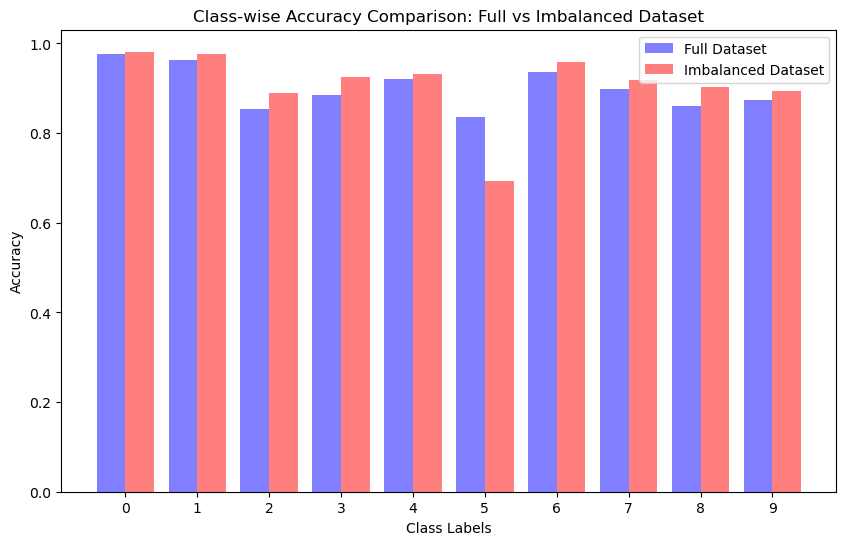

In [84]:
class_labels = list(range(10))

# Plot class-wise accuracy for the full dataset and the imbalanced dataset
plt.figure(figsize=(10,6))
plt.bar(class_labels, class_accuracies_full, width=0.4, label='Full Dataset', align='center', color='blue', alpha=0.5)
plt.bar([x + 0.4 for x in class_labels], class_accuracies_remove_samples, width=0.4, label='Imbalanced Dataset', align='center', color='red', alpha=0.5)

plt.xlabel('Class Labels')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy Comparison: Full vs Imbalanced Dataset')
plt.xticks([x + 0.2 for x in class_labels], class_labels)  # Center the ticks
plt.legend()
plt.show()

According to the bar plot, the accuracy of the model's prediction for samples labeled 5 drops significantly compared to other classes, meaning that the difference is **not homogenous** and is likely caused by the reduction of sample size in class 5.

#### 3. What happens if you change parameters like the learning rate and momentum? Plot the difference.

In [89]:
# original params:
# learning_rate = 0.001
# momentum = 0.1

parameters_set = {"learning_rate": [0.1, 0.01, 0.001],
                  "momentum": [0.1, 0.3, 0.5]}

parameter_results = {}
n_epochs = 5

In [99]:
def train_diff_params(network, optimizer, epoch, train_loader, dir):
    network.train()
    train_losses = []
    train_counter = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  
        output = network(data.reshape(-1, 28*28)) 
        loss = F.nll_loss(output, target)  
        loss.backward()  
        optimizer.step()  

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset)))
            
            torch.save(network.state_dict(), f'{dir}/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'{dir}/optimizer_iteration-{epoch}.pth')
    
    return train_losses, train_counter
# can be simplified by one general train func
    

In [100]:
def test_diff_params(network, test_loader):
    network.eval() 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.data.max(1, keepdim=True)[1]  
            correct += pred.eq(target.view_as(pred)).sum().item() 
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

    return test_loss, test_accuracy

In [101]:
import os

In [103]:
test_counter_diff_params = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [108]:
for lr in parameters_set['learning_rate']:
    for m in parameters_set['momentum']:
        print(f"Training with learning rate {lr} and momentum {m}")

        network = FeedforwardNeuralNetModel()
        optimizer = optim.SGD(network.parameters(), lr=lr, momentum=m)

        test_losses = []
        test_accuracies = []

        dir = f'./results_diff_params/results_lr_{lr}_momentum_{m}'  
        os.makedirs(dir, exist_ok=True) 
        
        train_counter = []
        train_losses = []
        
        for epoch in range(1, n_epochs + 1):
            tl, tc = train_diff_params(network, optimizer, epoch, train_loader, dir)
            test_loss, test_accuracy = test_diff_params(network, test_loader)
            
            train_counter.extend(tc)
            train_losses.extend(tl)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
        
        parameter_results[(lr, m)] = {
            'train_losses': train_losses,
            'train_counter': train_counter,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }

Training with learning rate 0.1 and momentum 0.1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361731
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.492596
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.548972


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.391265
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.696446
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.304270
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.401941
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.488920
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.464912
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.265173
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.493993
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.272263
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.568767
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.222454
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.433247
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.221198
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.590820
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.319258
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.177420
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.316945
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.387566
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.448134
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.519189
Train Epoch: 1 [147

In [106]:
result_1 = parameter_results[(0.1,0.1)]

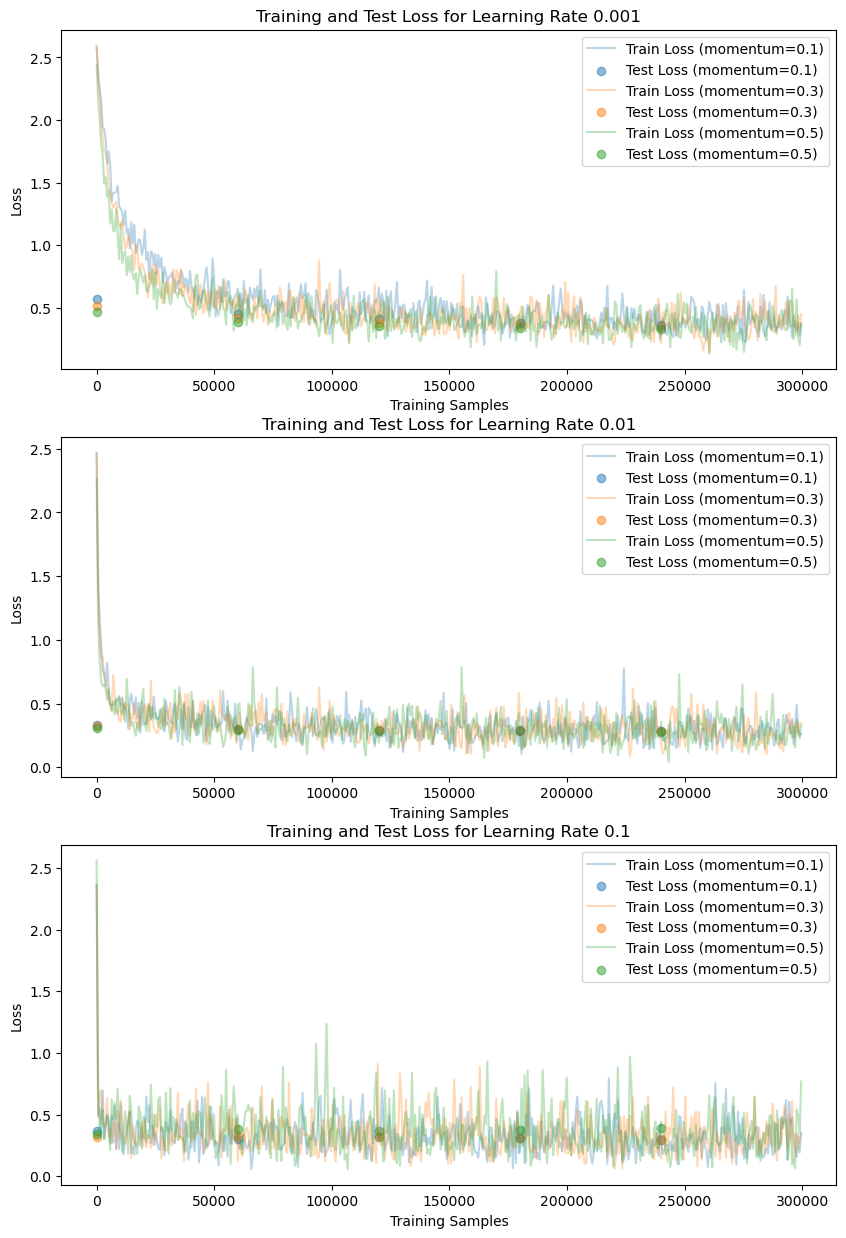

In [120]:
# compare losses with different momentums while keeping lr constant
learning_rates = sorted(set([lr for (lr, _) in parameter_results.keys()]))

fig, axes = plt.subplots(len(learning_rates), 1, figsize=(10, 5 * len(learning_rates)))

for i, lr in enumerate(learning_rates):
    ax = axes[i]  
    ax.set_title(f'Training and Test Loss for Learning Rate {lr}')
    
    for (lr_value, m), result in parameter_results.items():
        if lr_value == lr:
            ax.plot(result['train_counter'], result['train_losses'], 
                    label=f"Train Loss (momentum={m})", alpha=0.3)
            ax.scatter(test_counter_diff_params[:-1], result['test_losses'], 
                       label=f"Test Loss (momentum={m})", alpha=0.5)
    
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')


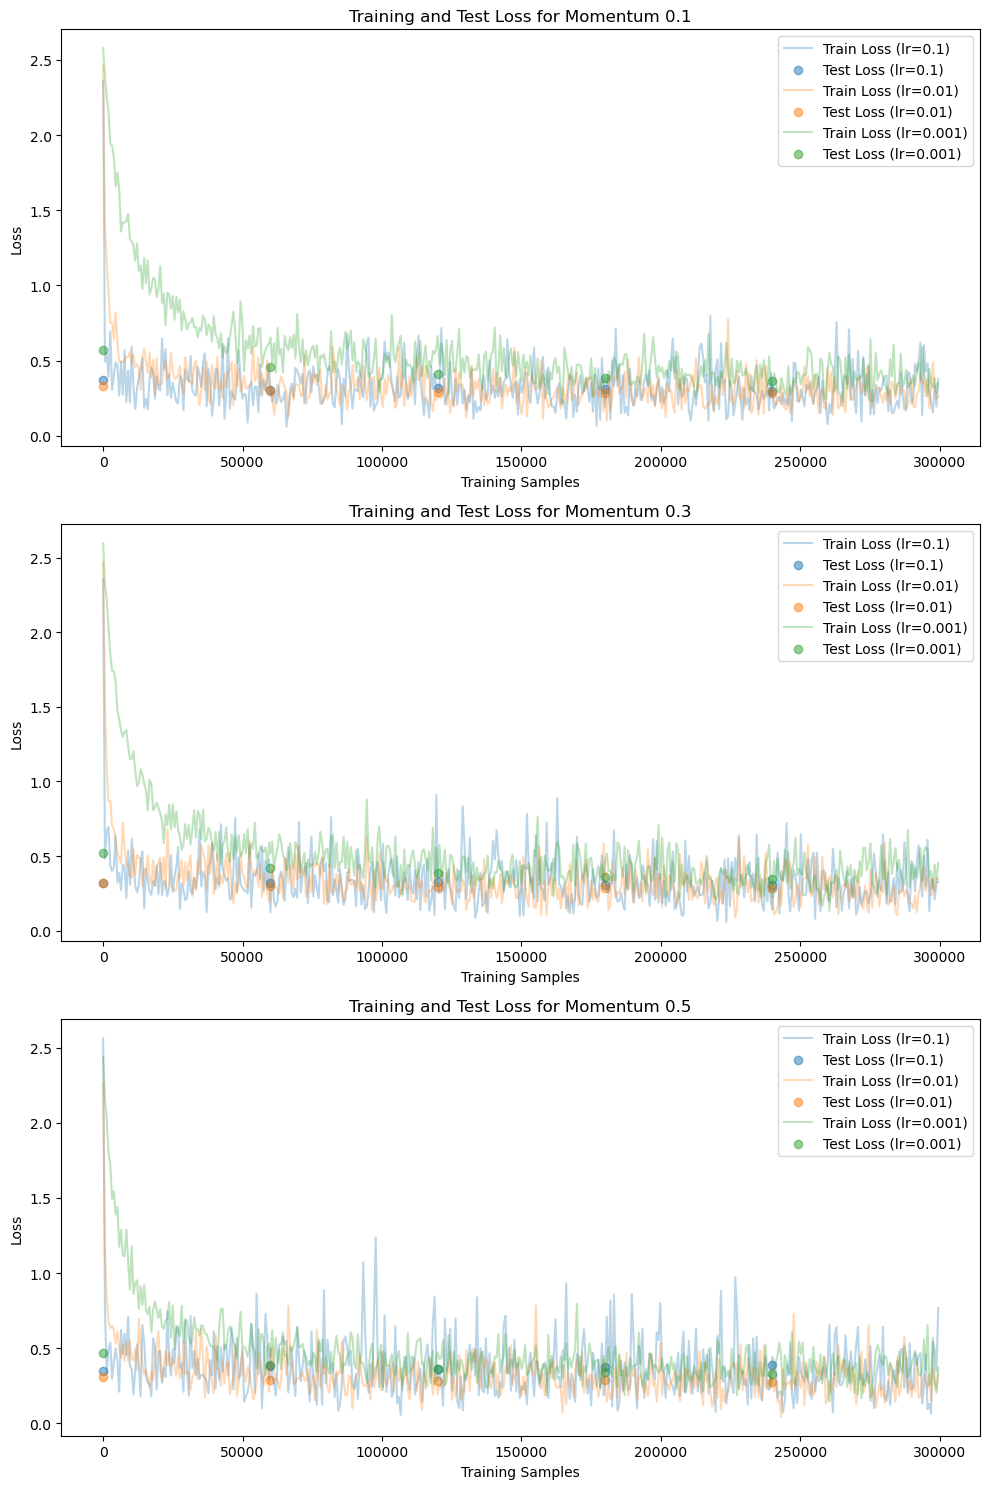

In [121]:
# compare losses with different lr while keeping momentum constant
momentums = sorted(set([m for (_, m) in parameter_results.keys()]))

fig, axes = plt.subplots(len(momentums), 1, figsize=(10, 5 * len(momentums)))

for i, m in enumerate(momentums):
    ax = axes[i]  
    ax.set_title(f'Training and Test Loss for Momentum {m}')
    
    for (lr, m_value), result in parameter_results.items():
        if m_value == m:
            ax.plot(result['train_counter'], result['train_losses'], 
                    label=f"Train Loss (lr={lr})", alpha=0.3)
            ax.scatter(test_counter_diff_params[:-1], result['test_losses'], 
                       label=f"Test Loss (lr={lr})", alpha=0.5)
    
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

- At lower learning rates, the effect of momentum is negligible, and the training/test losses for different momentum values are very similar.
- At higher learning rates, momentum has a noticeable impact, and higher momentum values (0.3 and 0.5) can cause greater fluctuations in the loss, indicating instability during training.

- For all learning rates, momentum 0.1 leads to the most stable training process. The training and test losses converge smoothly, with minimal fluctuations, especially for learning rates 0.001 and 0.01.
- As momentum increases (0.3 and 0.5), there are more oscillations, especially at the higher learning rate of 0.1. This could be attributed to the combination of high learning rate and high momentum.


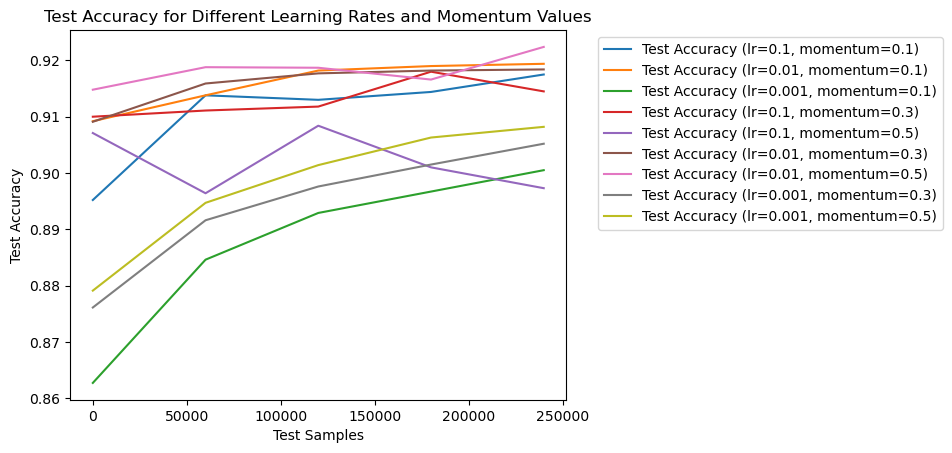

In [124]:
# Plotting testing accuracy of different combinations of parameters
fig = plt.figure()
for (lr, m), result in parameter_results.items():
    plt.plot(test_counter_diff_params[:-1], result['test_accuracies'], 
             label=f"Test Accuracy (lr={lr}, momentum={m})")

plt.xlabel('Test Samples')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Learning Rates and Momentum Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The best performing configurations appear to be:
- Learning rate = 0.1, Momentum = 0.1 (Blue line), which maintains strong and stable accuracy above 91%.
- Learning rate = 0.01, Momentum = 0.1 (Orange line), which also shows stable performance around 91%.

While higher momentum can sometimes start strong, it may introduce instability, especially at higher learning rates. The accuracy either fluctuates or dips as training progresses.

In [94]:
import pandas as pd

# save results
rows = []

for (lr, momentum), result in parameter_results.items():
    for epoch in range(n_epochs):
        rows.append({
            'learning_rate': lr,
            'momentum': momentum,
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'test_loss': result['test_losses'][epoch],
            'test_accuracy': result['test_accuracies'][epoch]
        })

# Convert list of dictionaries to DataFrame
df_results = pd.DataFrame(rows)

# Save the DataFrame to a CSV file
df_results.to_csv('experiment_results.csv', index=False)

print(df_results.head())

   learning_rate  momentum  epoch  train_loss  test_loss  test_accuracy
0            0.1       0.1      1    2.559034   0.374659         0.8996
1            0.1       0.1      2    2.358865   0.355712         0.9063
2            0.1       0.1      3    1.931374   0.347716         0.9089
3            0.1       0.1      4    1.279043   0.399741         0.8939
4            0.1       0.1      5    1.440282   0.365752         0.9074


#### 4. Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?

In [171]:
! mkdir -p results_hidden_layer_5
! mkdir -p results_hidden_layer_10

In [182]:
! mkdir -p results_10

In [136]:
class FeedforwardNeuralNetWithHiddenLayer(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        num_node_1 = 128
        super(FeedforwardNeuralNetWithHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_node_1)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(num_node_1, num_classes)     # Output layer
    
    def forward(self, x):
        x = F.relu(self.fc1(x))           
        x = self.fc2(x)                   
        return F.log_softmax(x, dim=1) 

In [170]:
network_hidden = FeedforwardNeuralNetWithHiddenLayer()
optimizer_hidden = optim.SGD(network_hidden.parameters(), lr=0.001, momentum=0.1)
# same params as original

n_epochs = 5
train_losses_hidden_5 = []
test_losses_hidden_5 = []
train_counter_hidden_5 = []
test_counter_hidden_5 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_hidden_5 = []

In [172]:
# use the train/test functions defined above
# train the hidden layer model for 5 epochs
for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_hidden, optimizer_hidden, epoch, train_loader, './results_hidden_layer_5'
    )
    test_loss, test_accuracy = test_diff_params(network_hidden, test_loader)

    train_counter_hidden_5.extend(tc)
    train_losses_hidden_5.extend(tl)
    
    test_losses_hidden_5.append(test_loss)
    test_accuracies_hidden_5.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368077
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.328128
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.296586
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.232483
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.216826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.204440
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.223142
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.162306
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.251550
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.129249
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.131136
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.121462
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.059747
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.074728
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.051429
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.063242
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.030369
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.975389
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.924101
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.954746
Train Epoch: 1 [12800/60000 (

In [173]:
network_hidden_10 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_hidden_10 = optim.SGD(network_hidden_10.parameters(), lr=0.001, momentum=0.1)
# same params as original

n_epochs = 10
train_losses_hidden_10 = []
test_losses_hidden_10 = []
train_counter_hidden_10 = []
test_counter_hidden_10 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_hidden_10 = []

# train the hidden layer model for 10 epochs
for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_hidden_10, optimizer_hidden_10, epoch, train_loader, './results_hidden_layer_10'
    )
    test_loss, test_accuracy = test_diff_params(network_hidden_10, test_loader)

    train_counter_hidden_10.extend(tc)
    train_losses_hidden_10.extend(tl)
    
    test_losses_hidden_10.append(test_loss)
    test_accuracies_hidden_10.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339762
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.360508
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.334809
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.350040
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.298133
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.268827
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.285046
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222948
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.261168
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.203997
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.203359
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.176809
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.120836
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.093311
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.120555
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.062280
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.029013
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.996436
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.029881
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.990399
Train Epoch: 1 [12800/60000 (

In [183]:
# Train the original model for 10 epochs
network_10 = FeedforwardNeuralNetModel()
optimizer_10 = optim.SGD(network_10.parameters(), lr=0.001, momentum=0.1)
n_epochs = 10

train_losses_10 = []
train_counter_10 = []
test_losses_10 = []
test_counter_10 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_10 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_10, optimizer_10, epoch, train_loader, './results_10'
    )
    test_loss, test_accuracy = test_diff_params(network_10, test_loader)

    train_counter_10.extend(tc)
    train_losses_10.extend(tl)
    
    test_losses_10.append(test_loss)
    test_accuracies_10.append(test_accuracy)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.465651
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.318489
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.249609
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.114233
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.088551
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.048594
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.845654
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.719574
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595935
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.568545
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.634293
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386301
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.443622
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.336319
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.286260
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.465598
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.229427
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.177303
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.154616
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.205579
Train Epoch: 1 [12800/60000 (

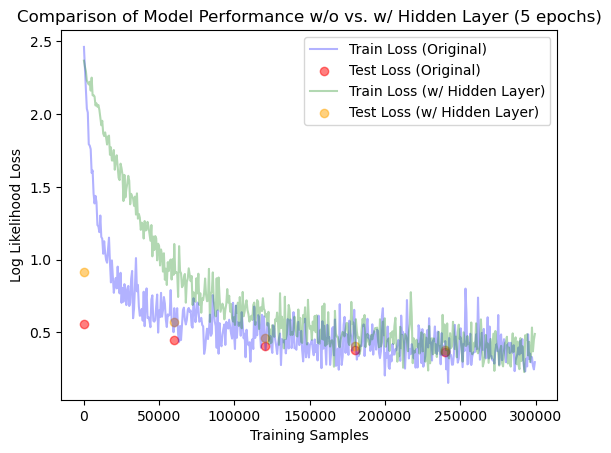

In [181]:
# compare training and testing losses w/ and w/o hidden layers (5 epoches)
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5, label="Test Loss (Original)")
pl.plot(train_counter_hidden_5, train_losses_hidden_5, color="green", alpha=0.3, label="Train Loss (w/ Hidden Layer)")
pl.scatter(test_counter_hidden_5[:-1], test_losses_hidden_5, color="orange", alpha=0.5, label="Test Loss (w/ Hidden Layer)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/o vs. w/ Hidden Layer (5 epochs)")
pl.legend()

pl.show()

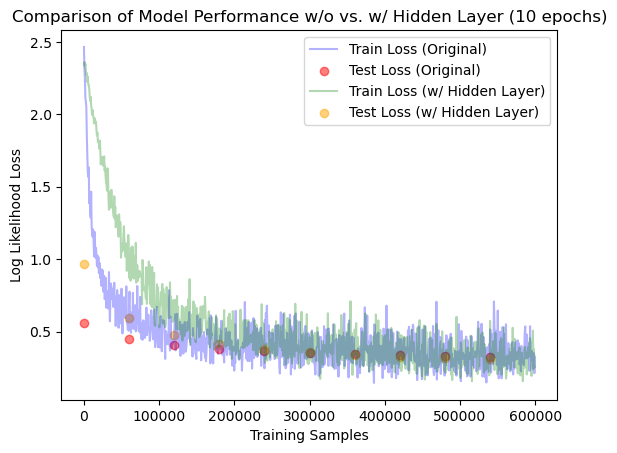

In [184]:
# compare training and testing losses w/ and w/o hidden layers (10 epoches)
fig = pl.figure()
pl.plot(train_counter_10, train_losses_10, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter_10[:-1], test_losses_10, color="red", alpha=0.5, label="Test Loss (Original)")
pl.plot(train_counter_hidden_10, train_losses_hidden_10, color="green", alpha=0.3, label="Train Loss (w/ Hidden Layer)")
pl.scatter(test_counter_hidden_10[:-1], test_losses_hidden_10, color="orange", alpha=0.5, label="Test Loss (w/ Hidden Layer)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/o vs. w/ Hidden Layer (10 epochs)")
pl.legend()

pl.show()

The training and testing losses of the model with hidden layer decrease slower than the ones of the model without hidden layer, which indicates the hidden layer model has a slower learning process initially. This may be because the hidden layer introduces more complexity and needs more data and time to optimize effectively. 

Despite that, the hidden layer model's performance improves steadily. As shown in the second comparison (with 10 epochs), the hidden layer model's training and testing losses catch up with the ones of the original model and eventually exceeds it. This proves that given enough training data and time, the hidden layer model can outperform the original model by learning more complex patterns and generalize better.

In [153]:
original_test_accuracies = parameter_results[(0.01,0.1)]['test_accuracies']

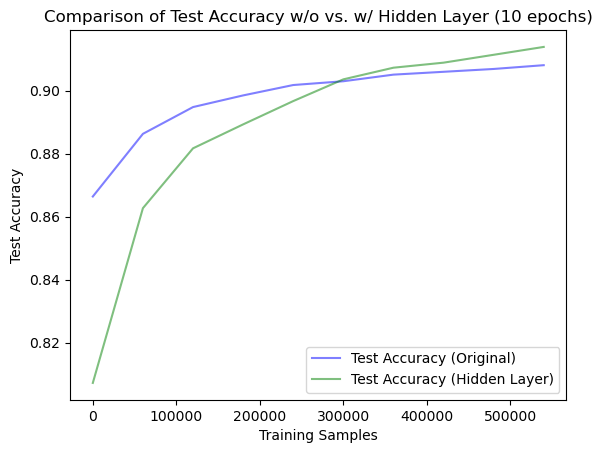

In [186]:
# compare test accuracies w/o and w/ hidden layer
fig = pl.figure()
plt.plot(test_counter_10[:-1], test_accuracies_10, label="Test Accuracy (Original)", color="blue", alpha=0.5)
plt.plot(test_counter_hidden_10[:-1], test_accuracies_hidden_10, label="Test Accuracy (Hidden Layer)", color="green", alpha=0.5)
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy w/o vs. w/ Hidden Layer (10 epochs)")
plt.legend()
plt.show()

The original model demonstrates a steadier increase in test accuracy in general, but plateaus after about 300k samples. The hidden layer model has a lower initial test accuracy, but increases more rapidly and surpasses the original model after about 300k samples. 

This observation matches the trend in losses showcased above, which reflect the hidden layer's traits of having a slower initial learning process as well as having more potential to learn complex patterns and generalize better. 

#### 5. Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?

L1: lasso

L2: ridge

Dropout: drops a fraction of neurons randomly during training

In [215]:
! mkdir -p results_l1_reg
! mkdir -p results_l2_reg
! mkdir -p results_dropout_reg
! mkdir -p results_no_reg

In [216]:
n_epochs = 5

In [228]:
# model with no regularization (I increased the learning rate compared to the original one)

network_no_reg = FeedforwardNeuralNetModel()
optimizer_no_reg = optim.SGD(network_no_reg.parameters(), lr=0.05, momentum=0.1)

train_losses_no_reg = []
train_counter_no_reg = []
test_losses_no_reg = []
test_counter_no_reg = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_no_reg = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_no_reg, optimizer_no_reg, epoch, train_loader, './results_no_reg'
    )
    test_loss, test_accuracy = test_diff_params(network_no_reg, test_loader)

    train_counter_no_reg.extend(tc)
    train_losses_no_reg.extend(tl)
    
    test_losses_no_reg.append(test_loss)
    test_accuracies_no_reg.append(test_accuracy)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_40336/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.494615
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.751895
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.473408
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.503897
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.412633
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.576686
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.391972
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.557142
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.443162
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.485831
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.344426
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.474416
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.434659
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.528041
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.657160
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.608379
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.584368
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.471037
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.395480
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.278346
Train Epoch: 1 [12800/60000 (

In [219]:
# add L1
def l1_penalty(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

l1_lambda = 0.01  

def train_with_l1(network, optimizer, epoch, train_loader, dir):
    network.train()

    train_losses = []
    train_counter = []

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.view(-1, 28*28))  # Flatten input images
        loss = F.nll_loss(output, target)  
        loss += l1_penalty(network, l1_lambda)  # Add L1 penalty to loss
        loss.backward()  
        optimizer.step()  
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset))
            )

            torch.save(network.state_dict(), f'{dir}/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'{dir}/optimizer_iteration-{epoch}.pth')
    
    return train_losses, train_counter

network_l1 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_l1 = optim.SGD(network_l1.parameters(), lr=0.05, momentum=0.1)

train_losses_l1 = []
test_losses_l1 = []
train_counter_l1 = []
test_counter_l1 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_l1 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_with_l1(network_l1, optimizer_l1, epoch, train_loader, './results_l1_reg')
    test_loss, test_accuracy = test_diff_params(network_l1, test_loader)

    train_counter_l1.extend(tc)
    train_losses_l1.extend(tl)

    test_losses_l1.append(test_loss)
    test_accuracies_l1.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 20.887300
Train Epoch: 1 [640/60000 (1%)]	Loss: 15.005618
Train Epoch: 1 [1280/60000 (2%)]	Loss: 10.633589
Train Epoch: 1 [1920/60000 (3%)]	Loss: 7.239679
Train Epoch: 1 [2560/60000 (4%)]	Loss: 5.049779
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.534860
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.851463
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.755600
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.524086
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.624824
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.368684
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.205202
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.468102
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.190031
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.031761
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.025918
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.965698
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.858422
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.935183
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.820324
Train Epoch: 1 [12800/6000

In [220]:
# add L2
network_l2 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_l2 = optim.SGD(network_l2.parameters(), lr=0.05, momentum=0.1, weight_decay=0.01)

train_losses_l2 = []
test_losses_l2 = []
train_counter_l2 = []
test_counter_l2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_l2 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_with_l1(network_l2, optimizer_l2, epoch, train_loader, './results_l2_reg')
    test_loss, test_accuracy = test_diff_params(network_l2, test_loader)

    train_counter_l2.extend(tc)
    train_losses_l2.extend(tl)

    test_losses_l2.append(test_loss)
    test_accuracies_l2.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 20.804251
Train Epoch: 1 [640/60000 (1%)]	Loss: 15.077888
Train Epoch: 1 [1280/60000 (2%)]	Loss: 10.624482
Train Epoch: 1 [1920/60000 (3%)]	Loss: 7.134374
Train Epoch: 1 [2560/60000 (4%)]	Loss: 4.758253
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.420762
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.757910
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.546269
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.553742
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.495018
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.372551
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.107095
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.093255
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.149415
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.930484
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.934528
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.861680
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.914644
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.830729
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.946645
Train Epoch: 1 [12800/6000

In [221]:
# add drop-out
class FeedforwardNeuralNetWithDropout(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        num_nodes = 128
        dropout_rate = 0.5

        super(FeedforwardNeuralNetWithDropout, self).__init__()
        # Input layer: 28*28 -> Hidden layer
        self.fc1 = nn.Linear(input_dim, num_nodes)
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate) 
        # Hidden layer -> Output layer
        self.fc2 = nn.Linear(num_nodes, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
network_dropout = FeedforwardNeuralNetWithDropout()
optimizer_dropout = optim.SGD(network_dropout.parameters(), lr=0.05, momentum=0.1)

# Train the model with dropout regularization
train_losses_dropout = []
test_losses_dropout = []
train_counter_dropout = []
test_counter_dropout = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_dropout = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_dropout, optimizer_dropout, epoch, train_loader, './results_dropout_reg'
    )
    test_loss, test_accuracy = test_diff_params(network_dropout, test_loader)

    train_counter_dropout.extend(tc)
    train_losses_dropout.extend(tl)

    test_losses_dropout.append(test_loss)
    test_accuracies_dropout.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343662
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.686267
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.406108
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.987693
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.774691
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.733570
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.487020
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.611623
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.601429
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.537099
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.633557
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.505665
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.399696
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.523259
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.430021
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.427881
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.457413
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.381626
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.442855
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.541841
Train Epoch: 1 [12800/60000 (

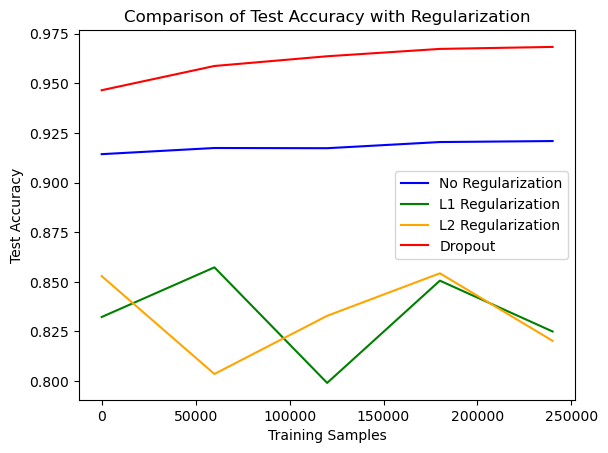

In [229]:
# Plot comparison of test accuracy with different regularizations
fig = plt.figure()
plt.plot(test_counter_no_reg[:-1], test_accuracies_no_reg, label="No Regularization", color="blue")
plt.plot(test_counter_l1[:-1], test_accuracies_l1, label="L1 Regularization", color="green")
plt.plot(test_counter_l2[:-1], test_accuracies_l2, label="L2 Regularization", color="orange")
plt.plot(test_counter_dropout[:-1], test_accuracies_dropout, label="Dropout", color="red")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy with Regularization")
plt.legend()
plt.show()

Dropout achieves the highest test accuracy, consistently improving as the training samples increase. By the end of training, it reaches an accuracy of about 0.97, which means t**he dropout regularization helps the model to generalize better and prevents overfitting**. The no regularization model have a relatively high accuracy, but does not improve too much after about 100k sampels. Both L1 and L2 regularized model show fluctuating test accuracies, which may suggest that these regularization techniques are not as effective in this case.

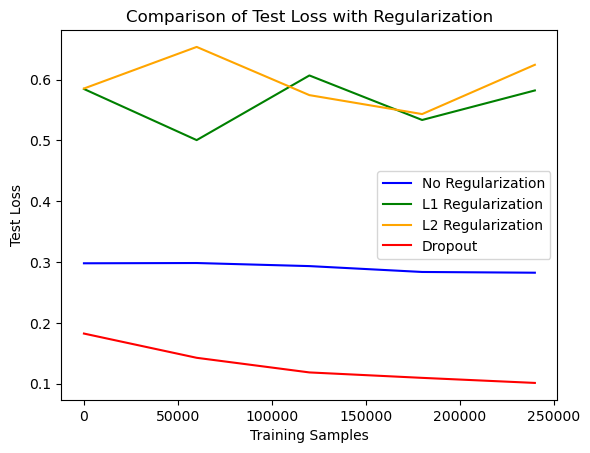

In [230]:
# Comparison of test loss with regularizations
fig = plt.figure()
plt.plot(test_counter_no_reg[:-1], test_losses_no_reg, label="No Regularization", color="blue")
plt.plot(test_counter_l1[:-1], test_losses_l1, label="L1 Regularization", color="green")
plt.plot(test_counter_l2[:-1], test_losses_l2, label="L2 Regularization", color="orange")
plt.plot(test_counter_dropout[:-1], test_losses_dropout, label="Dropout", color="red")
plt.xlabel("Training Samples")
plt.ylabel("Test Loss")
plt.title("Comparison of Test Loss with Regularization")
plt.legend()
plt.show()

The dropout model has the lowest test loss across all models. In the end, the test loss reaches 0.1, suggesting the regularization helps to reduce overfitting and the model fits the unseen data relatively well. The test loss for the model without regularization remains relatively high, which suggests that the model is not as efficient as minimizing loss as the dropout model. Both L1 and L2 regularization models show higher test losses which fluctuate more, indicating that these regularizations may be over-penalizing the model's weights.

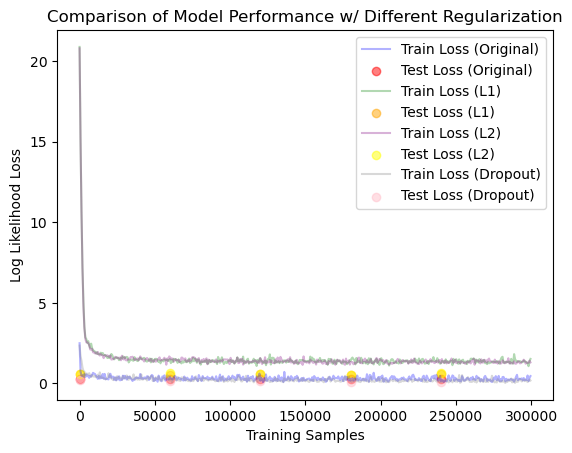

In [232]:
# compare training and testing losses w/ different regularization
fig = pl.figure()
pl.plot(train_counter_no_reg, train_losses_no_reg, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter_no_reg[:-1], test_losses_no_reg, color="red", alpha=0.5, label="Test Loss (Original)")
pl.plot(train_counter_l1, train_losses_l1, color="green", alpha=0.3, label="Train Loss (L1)")
pl.scatter(test_counter_l1[:-1], test_losses_l1, color="orange", alpha=0.5, label="Test Loss (L1)")
pl.plot(train_counter_l2, train_losses_l2, color="purple", alpha=0.3, label="Train Loss (L2)")
pl.scatter(test_counter_l2[:-1], test_losses_l2, color="yellow", alpha=0.5, label="Test Loss (L2)")
pl.plot(train_counter_dropout, train_losses_dropout, color="gray", alpha=0.3, label="Train Loss (Dropout)")
pl.scatter(test_counter_dropout[:-1], test_losses_dropout, color="pink", alpha=0.5, label="Test Loss (Dropout)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Different Regularization")
pl.legend()

pl.show()

Dropout continues to show the best overall performance both in terms of training and testing losses. L1 and L2 show higher training and testing losses, suggesting they may not be very suitable to improve the model. The no regularization model also performs relatively well in terms of training and testing losses. 

#### 6. [stretch] Can you change this model and turn it into a convolutional neural network?

#### Acknowledgement

I would like to acknowledge the assistance of OpenAI's ChatGPT in providing guidance and suggestions on implementing the regularization methods in question 5 of the final challenges.